In [15]:
import numpy as np
import pandas as pd
from keras import layers
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import pathlib
import cv2
import os

import random

In [9]:
path=pathlib.Path("C:/Users/ranus/alzheimer/archive(1)/OriginalDataset")
image=[]
categorie=[]
for dirname, _,filenames in os.walk(path):
    for filename in filenames:
        #print(os.path.join(dirname,filename))
        #image=image.append(str(path/filename/filenames))
        #categorie=categorie.append(str(filename))
        image+=[os.path.join(dirname, filename)]
        categorie+=[dirname.split('/')[-1]]

#data_df=pd.DataFrame(columns=['image','cate'])
#data_df['image']=image
#data_df['cate']=categorie
#data_df.head()
df=pd.DataFrame({"images":image,"categories":categorie})
df


,images,categories
0,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
1,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
2,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
3,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
4,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
...,...,...
6395,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
6396,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
6397,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...
6398,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...,C:\Users\ranus\alzheimer\archive(1)\OriginalDa...


In [10]:
data, data_test=train_test_split(df,test_size=0.25)
data_train, data_validation=train_test_split(data,test_size=0.33)

(208, 176, 3)

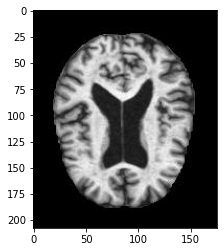

In [11]:
p=random.randint(0,data_train.shape[0])
p
photo=data_train.iloc[p,0]
image=cv2.imread(photo)/255
plt.imshow(image)
image.shape

## Classification

### Modele de CNN

In [17]:
model=tf.keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation="relu",input_shape=(208,176,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(4,activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 206, 174, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 103, 87, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 101, 85, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 40, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 20, 128)     

In [18]:
model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=["acc"])

### Traitement des données

In [ ]:
#from keras.preprocessing.image import ImageDataGenerator

#train_datagen=ImageDataGenerator(rescale=1./255)
#test_datagen=ImageDataGenerator(rescale=1./255)
def traitement(data):
    for i in range(0,data.shape[0]-1):
        images+=[cv2.imread(data.iloc[i:0])]
        labels+=[data.iloc[i:1]]